In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import pandas as pd
import seaborn as sns
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color=darkred> Dataset </font>

We provide below two datasets (one to train each model and another one to test each model).

Datasets contain input features (meteorological data) and output (kWh consumptions) to be predicted from the inputs.

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/DataS6Project/data_train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/DataS6Project/data_test.csv'

In [4]:
df_train = pd.read_csv(train_path)
df_train.head()

,temperature,humidity,horizontal_radiation,normal_radiation,heating,cooling,ventilation,gains
0,4.93,65.34,0.0,0.0,171.65,0.0,0,138.6
1,5.07,54.61,0.0,0.0,170.59,0.0,0,138.6
2,3.71,62.33,0.0,0.0,206.19,0.0,0,138.6
3,2.36,70.05,0.0,0.0,241.49,0.0,0,138.6
4,1.00,77.77,0.0,0.0,275.97,0.0,0,138.6


In [5]:
df_train.shape

(17520, 8)

In [6]:
df_test = pd.read_csv(test_path)
df_test.head()

,temperature,humidity,horizontal_radiation,normal_radiation,heating,cooling,ventilation,gains
0,7.09,88.42,0.0,0.0,0.00,0.0,0,138.6
1,4.00,88.58,0.0,0.0,7.18,0.0,0,138.6
2,2.23,87.25,0.0,0.0,125.72,0.0,0,138.6
3,2.52,87.17,0.0,0.0,106.85,0.0,0,138.6
4,2.72,89.17,0.0,0.0,104.25,0.0,0,138.6


In [7]:
df_test.shape

(8760, 8)

## Dataset Column Descriptions

1. **`temperature`**: The outdoor temperature (in degrees Celsius).

2. **`humidity`**: The relative humidity (in percentage).

3. **`horizontal_radiation`**: Solar radiation on a horizontal surface (measured in watts per square meter, W/m²). This indicates the amount of solar energy received by a horizontal plane.

4. **`normal_radiation`**: Solar radiation normal to a surface (measured in W/m²). This is useful for estimating the energy potential of inclined surfaces, such as solar panels or windows.

5. **`heating`**: The heating energy requirement (in kWh). This is the amount of energy needed to maintain indoor comfort when the temperature drops below the desired set point.

6. **`cooling`**: The cooling energy requirement (in kWh). This reflects the energy needed to cool a space to maintain comfort in warm conditions.

7. **`ventilation`**: The ventilation energy requirement (in kWh). It quantifies the energy consumed by ventilation systems to circulate air, which may include heating or cooling of the incoming air.

8. **`gains`**: Internal heat gains (in kWh). This represents the heat generated within the building from sources like appliances, people, lighting, and equipment.

#### Build input/output from dataframe

In [8]:
labels_output = ['heating','cooling','gains','ventilation']
labels_input = ['temperature','humidity','normal_radiation','horizontal_radiation']

In [9]:
def get_input_output(df,labels_usage,labels_input):
    dfX = df[labels_input]
    dfY = df[labels_usage]
    return dfX, dfY

In [10]:
dfX_train, dfY_train = get_input_output(df_train,labels_output,labels_input)
dfX_test, dfY_test = get_input_output(df_test,labels_output,labels_input)

In [11]:
def scaler_fit_transform(d_train,d_test):
    scaler = MinMaxScaler()
    data_train_sc = scaler.fit_transform(d_train)
    data_test_sc = scaler.transform(d_test)
    return scaler, data_train_sc, data_test_sc

In [12]:
scaler_x, X_train_sc, X_test_sc = scaler_fit_transform(dfX_train,dfX_test)
scaler_y, y_train_sc, y_test_sc = scaler_fit_transform(dfY_train,dfY_test)

In [14]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index:index+self.seq_len])

In [15]:
# We define a problem where we want to predict 1 week (7*24h) of output from the input
seq_len = 24*7
# Each gradient step uses batch_size sequences of input/output
batch_size = 16

In [16]:
def set_loader(X_train,y_train,X_test,y_test,seq_len,batch_size):
    train_dataset = TSDataset(torch.Tensor(X_train), torch.Tensor(y_train), seq_len)
    test_dataset = TSDataset(torch.Tensor(X_test), torch.Tensor(y_test), seq_len)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, drop_last=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [17]:
train_dataset, test_dataset, train_loader, test_loader = set_loader(X_train_sc,y_train_sc,X_test_sc,y_test_sc,seq_len,batch_size)

# Recurrent Neural Networks (RNN, LSTM and GRU)

## Models

### Simple Recurrent Neural Network (RNN)

In [18]:
class RNNmodel(nn.Module):
  def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
    """
    input_d (int): dimension of the input layer
    hidden_d (int): dimension of each layer
    layer_n (int): number of layers
    output_d (int): dimension of output layer
    dropout_p (float): probability of dropping neurons
    """
    super(RNNmodel, self).__init__()

    self.hidden_d = hidden_d
    self.layer_n = layer_n
    self.rnn = nn.RNN(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)
    self.dropout = nn.Dropout(dropout_p)
    self.fc = nn.Linear(hidden_d, output_d)

  def forward(self, x):
    """
    x (torch.Tensor): input tensor (batch size, sequence length, input_d)
    """
    h0 = torch.zeros(self.layer_n, x.size(0), self.hidden_d).to(x.device)
    out, h0 = self.rnn(x, h0)
    out = self.dropout(out)
    out = self.fc(out)
    return out

### Long Short Term Memory Neural Network (LSTM)

In [19]:
class LSTMmodel(nn.Module):
  def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
    """
    input_d (int): dimension of the input layer
    hidden_d (int): dimension of each layer
    layer_n (int): number of layers
    output_d (int): dimension of output layer
    dropout_p (float): probability of dropping neurons
    """
    super(LSTMmodel, self).__init__()

    self.hidden_d = hidden_d
    self.layer_n = layer_n
    self.rnn = nn.LSTM(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)
    self.dropout = nn.Dropout(dropout_p)
    self.fc = nn.Linear(hidden_d, output_d)


  def forward(self, x):
    """
    x (torch.Tensor): input tensor (batch size, sequence length, input_d)
    """
    h0 = torch.zeros(self.layer_n, x.size(0), self.hidden_d).to(x.device)
    c0 = torch.zeros(self.layer_n, x.size(0), self.hidden_d).to(x.device)
    out, h0 = self.rnn(x, (h0, c0))
    out = self.dropout(out)
    out = self.fc(out)
    return out

### Gated Recurrent Unit Neural Network (GRU)

In [20]:
class GRUmodel(nn.Module):
  def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
    """
    input_d (int): dimension of the input layer
    hidden_d (int): dimension of each layer
    layer_n (int): number of layers
    output_d (int): dimension of output layer
    dropout_p (float): probability of dropping neurons
    """
    super(GRUmodel, self).__init__()

    self.hidden_d = hidden_d
    self.layer_n = layer_n
    self.rnn = nn.GRU(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)
    self.dropout = nn.Dropout(dropout_p)
    self.fc = nn.Linear(hidden_d, output_d)

  def forward(self, x):
    """
    x (torch.Tensor): input tensor (batch size, sequence length, input_d)
    """
    h0 = torch.zeros(self.layer_n, x.size(0), self.hidden_d).to(x.device)
    out, h0 = self.rnn(x, h0)
    out = self.dropout(out)
    out = self.fc(out)
    return out

## Optimization

 - Complete the following class to optimize all models

In [21]:
for x_test, y_test in test_loader:
  print(x_test.shape)
  print(y_test.shape)
  break

torch.Size([16, 168, 4])
torch.Size([16, 168, 4])


In [22]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, device):
        """
        model: selected model
        loss_fn: loss function
        optimizer: function to optimize loss
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """
        x: input data
        y: target data
        """

        self.model.train()
        yhat = self.model.forward(x)
        loss = self.loss_fn(yhat, y)

        # Gradient for the optimization
        loss.backward()

        # Updates parameters
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, train_loader, val_loader, n_epochs=50, n_features=1):
        """
        train_loader: training data
        val_loader: validation data
        n_epochs: number of epochs
        n_features: number of features
        """
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)

            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(self.device)
                    y_val = y_val.to(self.device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(yhat, y_val).item()
                    batch_val_losses.append(val_loss)

                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        test_loader: dataLoader
        batch_size: batch size
        n_features: number of features
        """

        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(self.device)
                y_test = y_test.to(self.device)

                self.model.eval()
                yhat = self.model(x_test)

                yhat=yhat.cpu().data.numpy()
                predictions.append(yhat)
                y_test=y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values

    def plot_losses(self):
      plt.figure(figsize=(10, 6))
      plt.plot(self.train_losses, label="Training Loss")
      plt.plot(self.val_losses, label="Validation Loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.title("Training and Validation Loss")
      plt.legend()
      plt.grid()
      plt.show()

## Training

In [ ]:
# parameters of the neural networks
# input dimension
input_d = 4
# output dimension
output_d = 4
# hidden layers dimension
hidden_d = 8
#number of layers
layer_n = 2
#dropout probability
dropout_p = 0.2
# number of times all data are processed during training
n_epochs = 10
# parameters for the optimizer
lrate = 1e-4
weight_decay = 1e-6

In [ ]:
model_params = {'input_d': input_d,
                'hidden_d' : hidden_d,
                'layer_n' : layer_n,
                'output_d' : output_d,
                'dropout_p' : dropout_p}

In [ ]:
def get_model(model, model_params):
    models = {"rnn": RNNmodel,"lstm": LSTMmodel,"gru": GRUmodel}
    return models.get(model.lower())(**model_params)

In [ ]:
# default loss function: MSE
loss_fn = nn.MSELoss(reduction="mean")
device = "cuda" if torch.cuda.is_available() else "cpu"

 - Complete the following cell to train a RNN

[1/50] Training loss: 0.0966	 Validation loss: 0.0551
[2/50] Training loss: 0.0598	 Validation loss: 0.0551
[3/50] Training loss: 0.0578	 Validation loss: 0.0553
[4/50] Training loss: 0.0572	 Validation loss: 0.0554
[5/50] Training loss: 0.0569	 Validation loss: 0.0555
[6/50] Training loss: 0.0568	 Validation loss: 0.0554
[7/50] Training loss: 0.0567	 Validation loss: 0.0554
[8/50] Training loss: 0.0566	 Validation loss: 0.0556
[9/50] Training loss: 0.0565	 Validation loss: 0.0556
[10/50] Training loss: 0.0565	 Validation loss: 0.0555
[11/50] Training loss: 0.0564	 Validation loss: 0.0552
[12/50] Training loss: 0.0564	 Validation loss: 0.0555
[13/50] Training loss: 0.0563	 Validation loss: 0.0554
[14/50] Training loss: 0.0563	 Validation loss: 0.0555
[15/50] Training loss: 0.0561	 Validation loss: 0.0557
[16/50] Training loss: 0.0555	 Validation loss: 0.0568
[17/50] Training loss: 0.0553	 Validation loss: 0.0577
[18/50] Training loss: 0.0551	 Validation loss: 0.0572
[19/50] Training lo

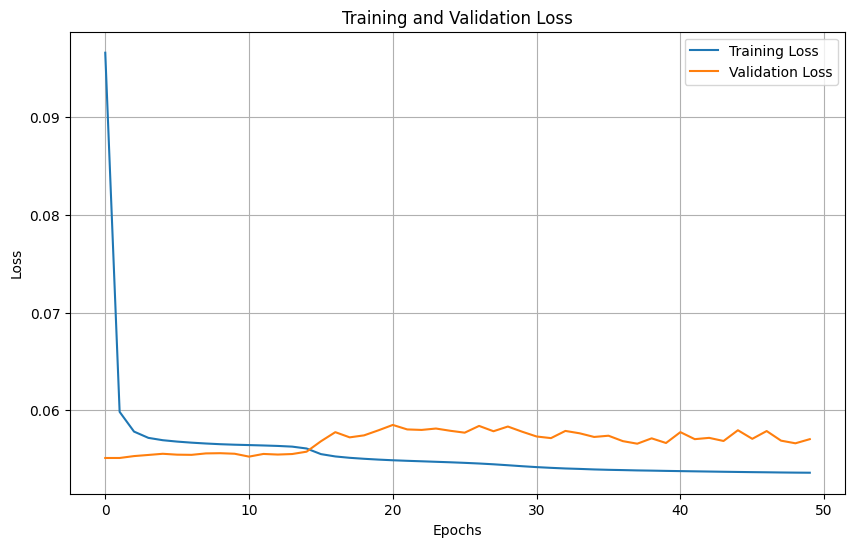

In [ ]:
model_name = 'rnn'
model = get_model(model_name, model_params)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)
opt_rnn = Optimization(model, loss_fn, optimizer, device)
opt_rnn.train(train_loader, test_loader)
opt_rnn.plot_losses()

 - Analyze the influence of the learning rate of the optimizer and of the batch size on the test and train losses

In [ ]:
lrs = [1e-6, 1e-4, 1e-2, 1, 10, 100]
opt_models = []
for lr in lrs:
  model = get_model(model_name, model_params)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  opt_rnn = Optimization(model, loss_fn, optimizer, device)
  opt_rnn.train(train_loader, test_loader)
  opt_models.append(opt_rnn)

[1/50] Training loss: 0.3505	 Validation loss: 0.3409
[2/50] Training loss: 0.3433	 Validation loss: 0.3339
[3/50] Training loss: 0.3365	 Validation loss: 0.3272
[4/50] Training loss: 0.3298	 Validation loss: 0.3208
[5/50] Training loss: 0.3235	 Validation loss: 0.3146
[6/50] Training loss: 0.3172	 Validation loss: 0.3085
[7/50] Training loss: 0.3112	 Validation loss: 0.3026
[8/50] Training loss: 0.3053	 Validation loss: 0.2969
[9/50] Training loss: 0.2996	 Validation loss: 0.2912
[10/50] Training loss: 0.2939	 Validation loss: 0.2858
[11/50] Training loss: 0.2885	 Validation loss: 0.2804
[12/50] Training loss: 0.2831	 Validation loss: 0.2751
[13/50] Training loss: 0.2777	 Validation loss: 0.2698
[14/50] Training loss: 0.2725	 Validation loss: 0.2647
[15/50] Training loss: 0.2673	 Validation loss: 0.2597
[16/50] Training loss: 0.2623	 Validation loss: 0.2547
[17/50] Training loss: 0.2573	 Validation loss: 0.2498
[18/50] Training loss: 0.2524	 Validation loss: 0.2450
[19/50] Training lo

Plotting the losses for the optimizer with the learning rate 1e-06


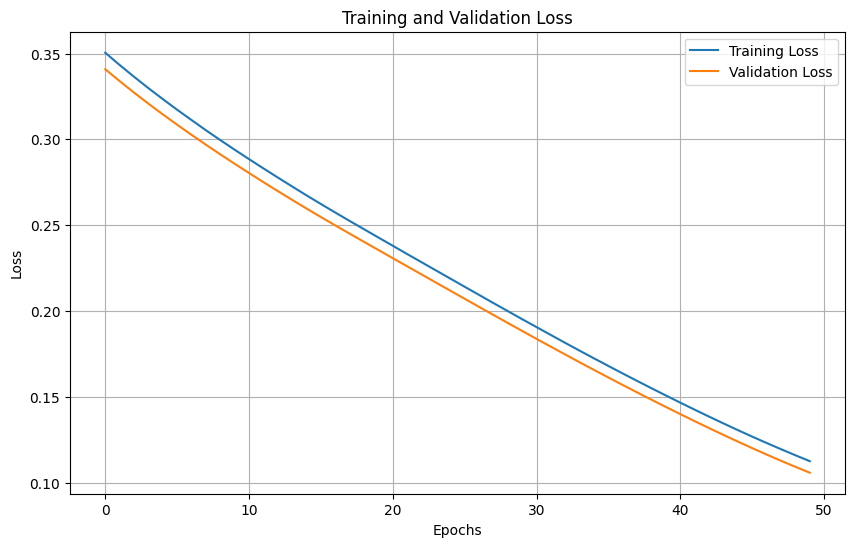

Plotting the losses for the optimizer with the learning rate 0.0001


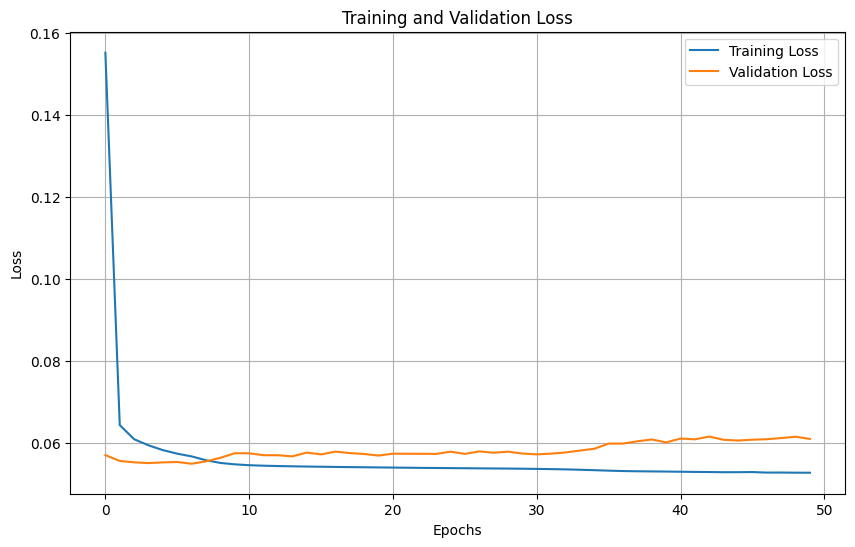

Plotting the losses for the optimizer with the learning rate 0.01


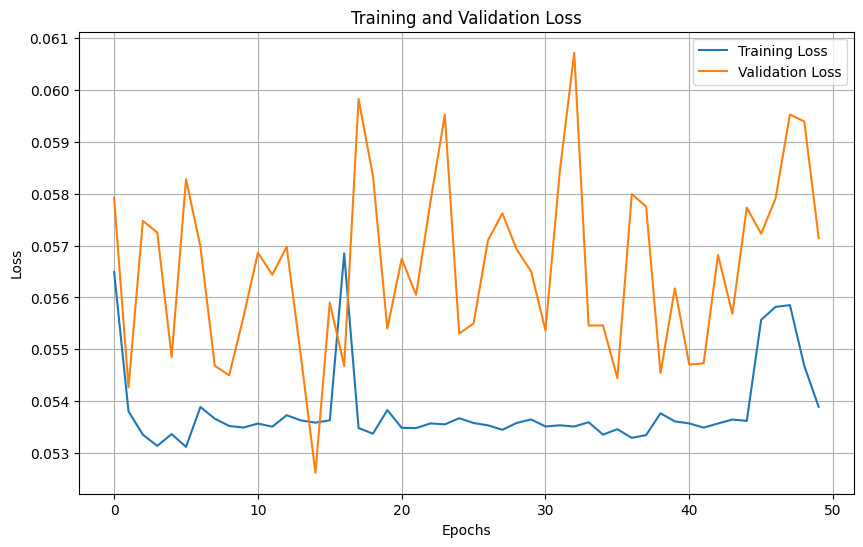

Plotting the losses for the optimizer with the learning rate 1


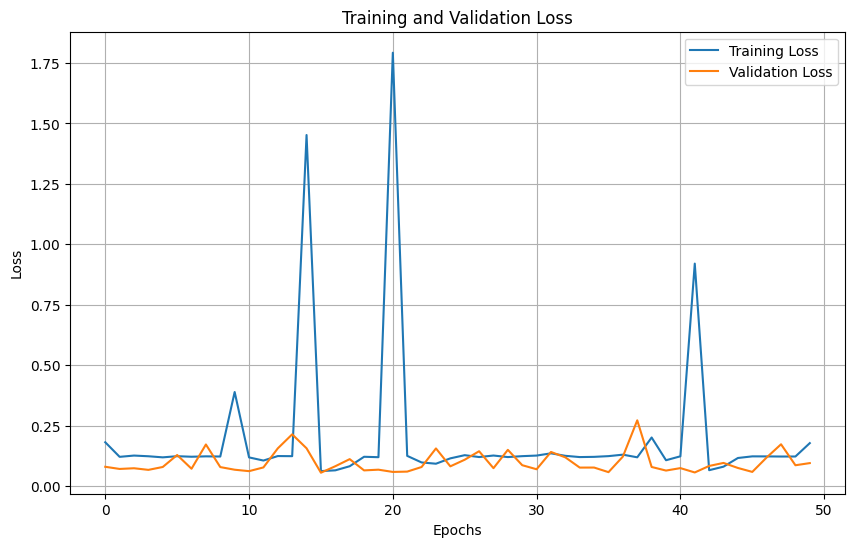

Plotting the losses for the optimizer with the learning rate 10


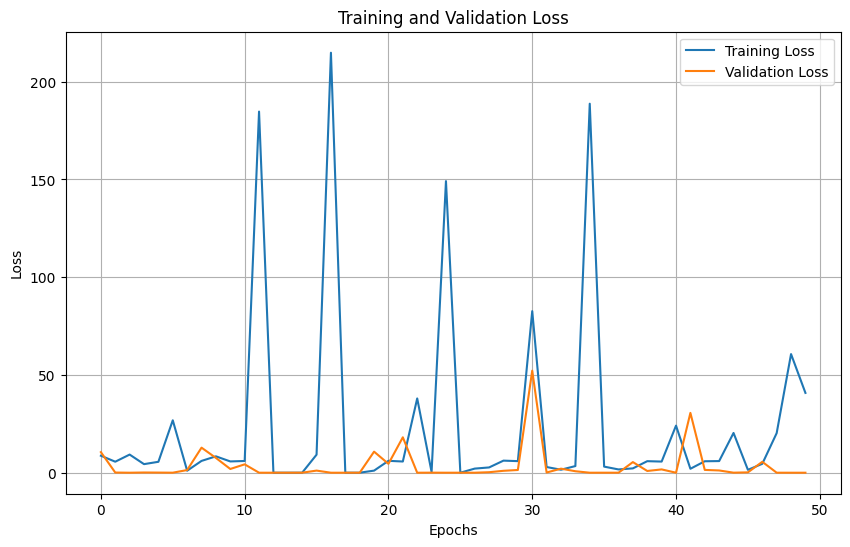

Plotting the losses for the optimizer with the learning rate 100


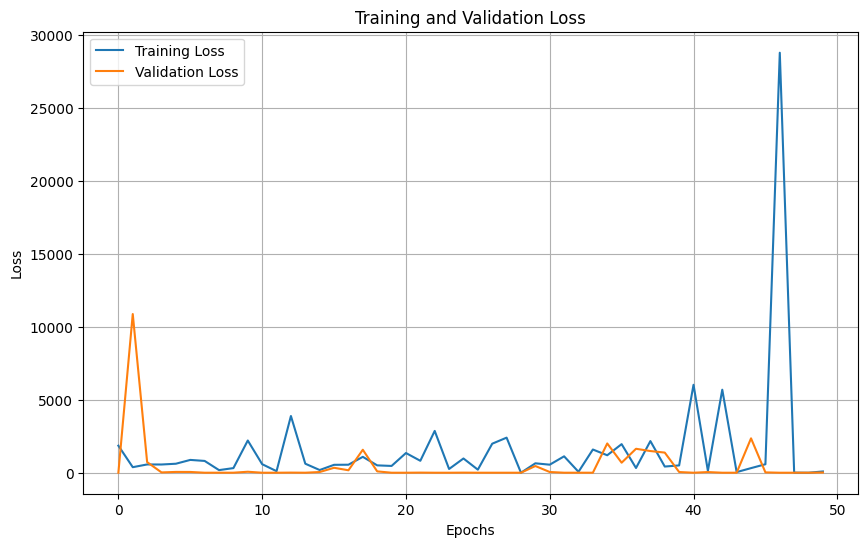

In [ ]:
for opt_model, lr in zip(opt_models, lrs):
  print(f'Plotting the losses for the optimizer with the learning rate {lr}')
  opt_model.plot_losses()

### Interpretation of Loss Plots for Different Learning Rates

Below, we analyze the training and validation loss curves for an RNN model trained using various learning rates.

**Learning Rate > $0.1$**
- Training and validation losses **oscillate significantly**.
- While the losses are not as erratic as with a learning rate of $10$ and $100$, they still indicate **instability** in the case of $1$.
- This learning rate is **too high** for stable training.

**Learning Rate: 0.01**
- Training loss decreases steadily, but the validation loss fluctuates significantly.
- The fluctuations suggest **potential overfitting** or sensitivity to the learning rate.
- This learning rate is **slightly high**.

**Learning Rate < $10^{-6}$**
- Both training and validation losses decrease smoothly and steadily over the epochs.
- This indicates that the learning rate is **too small**, causing very slow progress toward convergence and **ultimately not reaching the minimum**.
- While the losses do decrease, the training process is inefficient and time-consuming.

**Learning Rate = $10^{-4}$**
- The training loss decreases rapidly in the initial epochs and then **stabilizes**.
- The validation loss follows a similar trend but shows slight fluctuations as the training progresses.
- This learning rate is **close to optimal**, allowing the model to converge effectively while avoiding overfitting.



---

### Recommendations:
- Based on the plots, a learning rate around **0.0001** appears to be the most suitable for this model.
- Smaller learning rates (e.g., **1e-06**) lead to stable but slow convergence, while higher learning rates (e.g., **1**, **10**, or **100**) cause instability or divergence.
- Further experimentation around **0.0001** (e.g., testing 0.0005 or 0.00001) could help refine the model's performance.


 - Train a LSTM and a GRU model

[1/50] Training loss: 0.1614	 Validation loss: 0.0577
[2/50] Training loss: 0.0808	 Validation loss: 0.0564
[3/50] Training loss: 0.0710	 Validation loss: 0.0557
[4/50] Training loss: 0.0660	 Validation loss: 0.0553
[5/50] Training loss: 0.0630	 Validation loss: 0.0551
[6/50] Training loss: 0.0612	 Validation loss: 0.0548
[7/50] Training loss: 0.0597	 Validation loss: 0.0549
[8/50] Training loss: 0.0586	 Validation loss: 0.0550
[9/50] Training loss: 0.0579	 Validation loss: 0.0552
[10/50] Training loss: 0.0574	 Validation loss: 0.0550
[11/50] Training loss: 0.0571	 Validation loss: 0.0551
[12/50] Training loss: 0.0568	 Validation loss: 0.0548
[13/50] Training loss: 0.0566	 Validation loss: 0.0550
[14/50] Training loss: 0.0563	 Validation loss: 0.0553
[15/50] Training loss: 0.0557	 Validation loss: 0.0565
[16/50] Training loss: 0.0555	 Validation loss: 0.0566
[17/50] Training loss: 0.0554	 Validation loss: 0.0562
[18/50] Training loss: 0.0553	 Validation loss: 0.0573
[19/50] Training lo

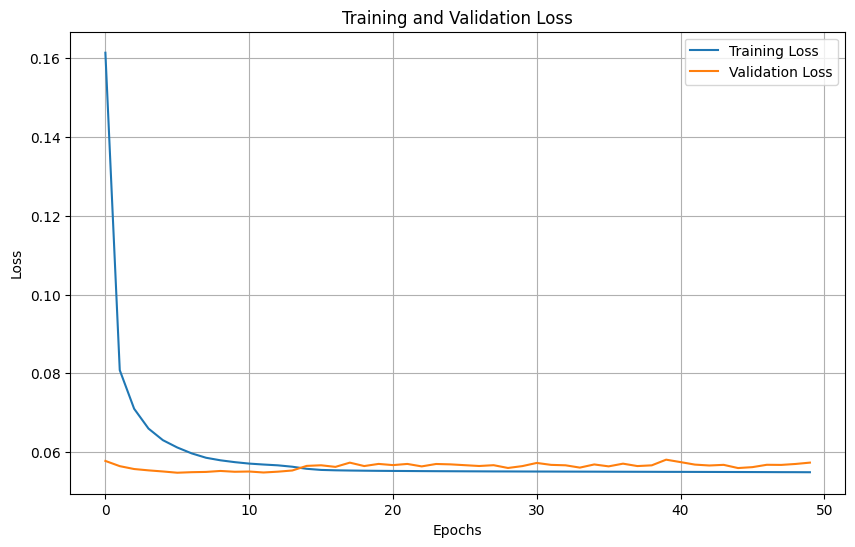

In [ ]:
model_rnn = get_model('rnn', model_params)
model_rnn.to(device)
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-4, weight_decay=weight_decay)
opt_rnn = Optimization(model_rnn, loss_fn, optimizer, device)
opt_rnn.train(train_loader, test_loader)
opt_rnn.plot_losses()

[1/50] Training loss: 0.1049	 Validation loss: 0.0577
[2/50] Training loss: 0.0676	 Validation loss: 0.0562
[3/50] Training loss: 0.0631	 Validation loss: 0.0555
[4/50] Training loss: 0.0608	 Validation loss: 0.0551
[5/50] Training loss: 0.0591	 Validation loss: 0.0552
[6/50] Training loss: 0.0577	 Validation loss: 0.0563
[7/50] Training loss: 0.0565	 Validation loss: 0.0563
[8/50] Training loss: 0.0558	 Validation loss: 0.0566
[9/50] Training loss: 0.0552	 Validation loss: 0.0568
[10/50] Training loss: 0.0548	 Validation loss: 0.0568
[11/50] Training loss: 0.0545	 Validation loss: 0.0576
[12/50] Training loss: 0.0542	 Validation loss: 0.0570
[13/50] Training loss: 0.0540	 Validation loss: 0.0577
[14/50] Training loss: 0.0538	 Validation loss: 0.0582
[15/50] Training loss: 0.0536	 Validation loss: 0.0590
[16/50] Training loss: 0.0535	 Validation loss: 0.0590
[17/50] Training loss: 0.0534	 Validation loss: 0.0598
[18/50] Training loss: 0.0533	 Validation loss: 0.0594
[19/50] Training lo

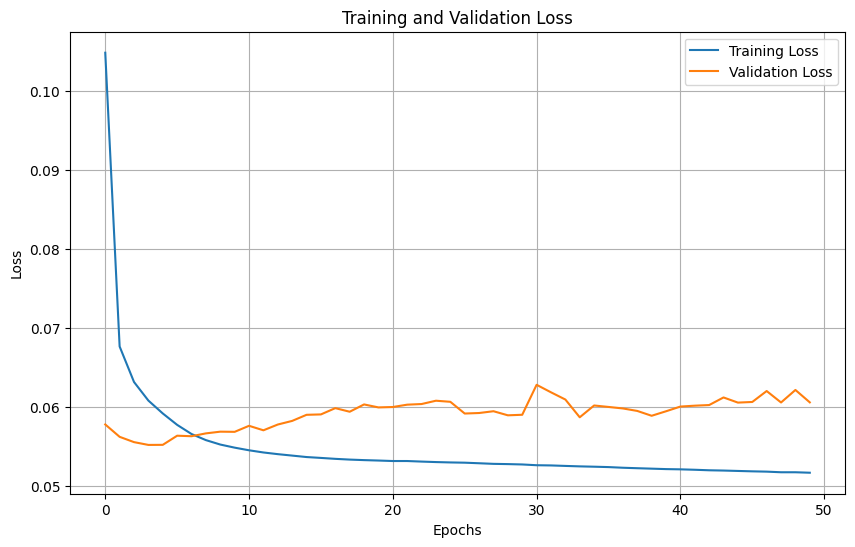

In [ ]:
model_lstm = get_model('lstm', model_params)
model_lstm.to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-4, weight_decay=weight_decay)
opt_lstm = Optimization(model_lstm, loss_fn, optimizer, device)
opt_lstm.train(train_loader, test_loader)
opt_lstm.plot_losses()

[1/50] Training loss: 0.0823	 Validation loss: 0.0561
[2/50] Training loss: 0.0651	 Validation loss: 0.0555
[3/50] Training loss: 0.0619	 Validation loss: 0.0552
[4/50] Training loss: 0.0600	 Validation loss: 0.0549
[5/50] Training loss: 0.0584	 Validation loss: 0.0548
[6/50] Training loss: 0.0575	 Validation loss: 0.0550
[7/50] Training loss: 0.0570	 Validation loss: 0.0551
[8/50] Training loss: 0.0568	 Validation loss: 0.0553
[9/50] Training loss: 0.0567	 Validation loss: 0.0553
[10/50] Training loss: 0.0565	 Validation loss: 0.0553
[11/50] Training loss: 0.0564	 Validation loss: 0.0556
[12/50] Training loss: 0.0561	 Validation loss: 0.0557
[13/50] Training loss: 0.0556	 Validation loss: 0.0567
[14/50] Training loss: 0.0553	 Validation loss: 0.0570
[15/50] Training loss: 0.0551	 Validation loss: 0.0574
[16/50] Training loss: 0.0550	 Validation loss: 0.0566
[17/50] Training loss: 0.0548	 Validation loss: 0.0571
[18/50] Training loss: 0.0547	 Validation loss: 0.0570
[19/50] Training lo

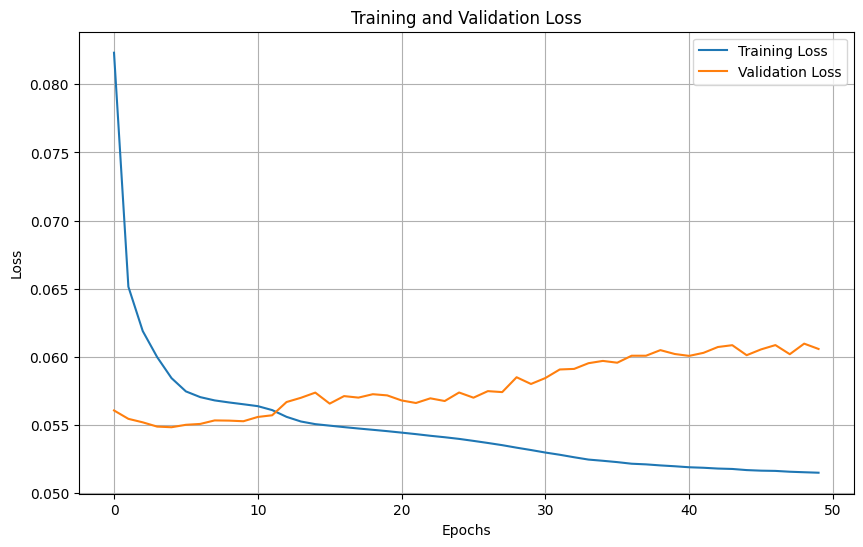

In [ ]:
model_gru = get_model('gru', model_params)
model_gru.to(device)
optimizer = optim.Adam(model_gru.parameters(), lr=1e-4, weight_decay=weight_decay)
opt_gru = Optimization(model_gru, loss_fn, optimizer, device)
opt_gru.train(train_loader, test_loader)
opt_gru.plot_losses()

- Compute the MSE for each model on the test set  and display some predictions to provide qualitative results

In [ ]:
rnn_pred, vals = opt_rnn.evaluate(test_loader)
lstm_pred, _ = opt_lstm.evaluate(test_loader)
gru_pred, _ = opt_gru.evaluate(test_loader)
rnn_pred = np.array(rnn_pred)
lstm_pred = np.array(lstm_pred)
gru_pred = np.array(gru_pred)
vals = np.array(vals)

In [ ]:
rnn_mse = np.mean(np.square(rnn_pred - vals))
lstm_mse = np.mean(np.square(lstm_pred - vals))
gru_mse = np.mean(np.square(gru_pred - vals))
print(f"MSE for RNN on test data: {rnn_mse}")
print(f"MSE for LSTM on test data: {lstm_mse}")
print(f"MSE for GRU on test data: {gru_mse}")

MSE for RNN on test data: 0.05731791630387306
MSE for LSTM on test data: 0.060541316866874695
MSE for GRU on test data: 0.06058098375797272


In [ ]:
# Reconstruct the original predictions and actual values for each model from the batches and the sequences
rnn_pred_c = np.concatenate([batch.squeeze() for batch in rnn_pred], axis=0)
rnn_pred_last = np.array([batch[-1] for batch in rnn_pred_c])

lstm_pred_c = np.concatenate([batch.squeeze() for batch in lstm_pred], axis=0)
lstm_pred_last = np.array([batch[-1] for batch in lstm_pred_c])

gru_pred_c = np.concatenate([batch.squeeze() for batch in gru_pred], axis=0)
gru_pred_last = np.array([batch[-1] for batch in gru_pred_c])

vals_c = np.concatenate([batch.squeeze() for batch in vals], axis=0)
vals_last = np.array([batch[-1] for batch in vals_c])

In [ ]:
# Inverse transform the scaled predictions and actual values using the scaler_y
rnn_pred_inv = scaler_y.inverse_transform(rnn_pred_last)
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred_last)
gru_pred_inv = scaler_y.inverse_transform(gru_pred_last)
vals_inv = scaler_y.inverse_transform(vals_last)

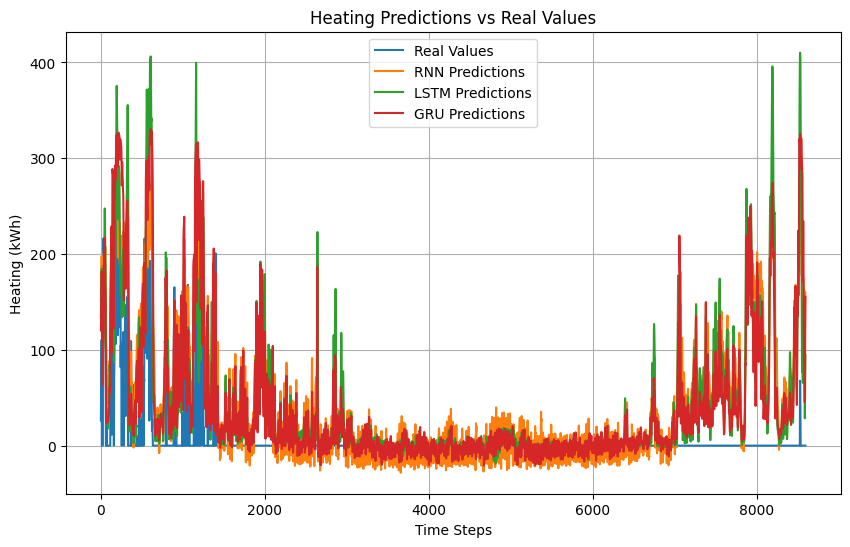

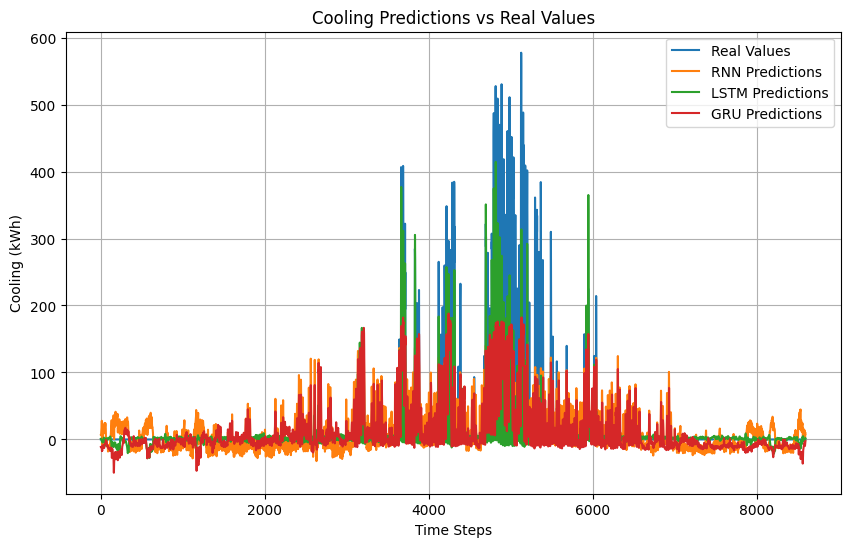

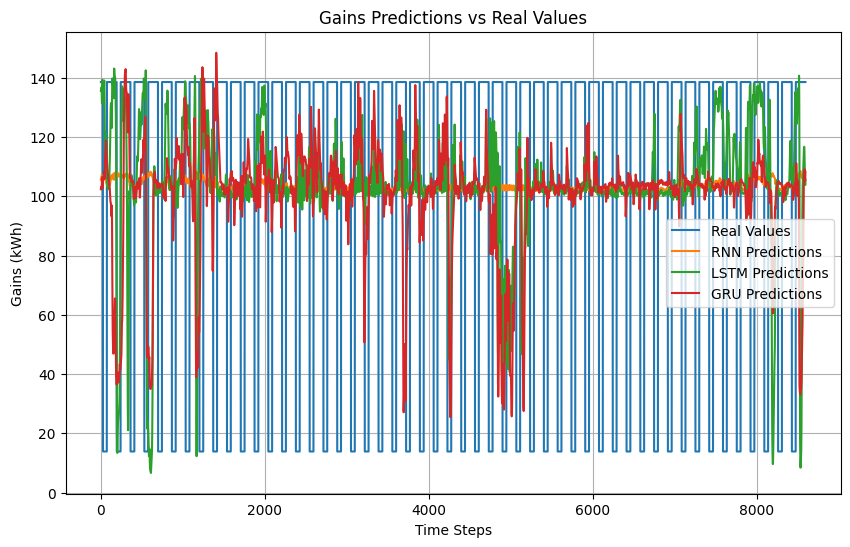

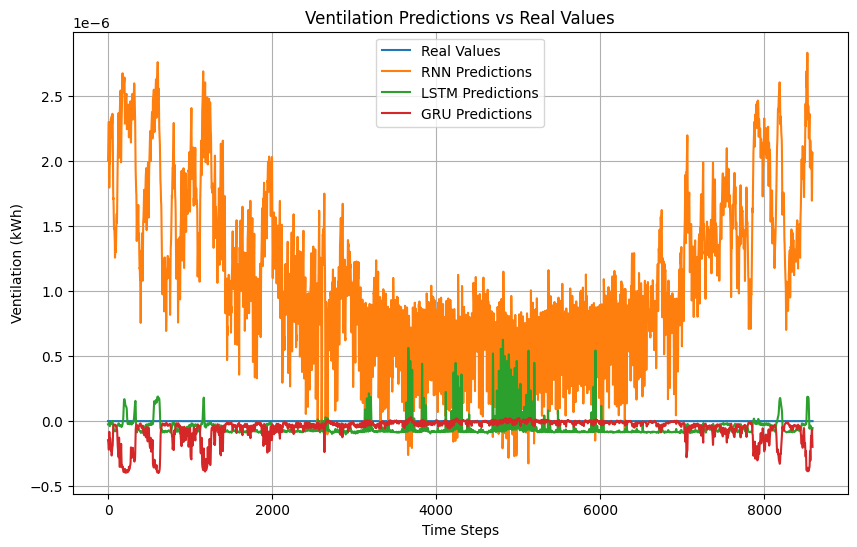

In [ ]:
# Plot the predictions against the real values for heating
plt.figure(figsize=(10, 6))
plt.plot(vals_inv[:,0], label='Real Values')
plt.plot(rnn_pred_inv[:,0], label='RNN Predictions')
plt.plot(lstm_pred_inv[:,0], label='LSTM Predictions')
plt.plot(gru_pred_inv[:,0], label='GRU Predictions')
plt.xlabel("Time Steps")
plt.ylabel("Heating (kWh)")
plt.title("Heating Predictions vs Real Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot the predictions against the real values for cooling
plt.figure(figsize=(10, 6))
plt.plot(vals_inv[:,1], label='Real Values')
plt.plot(rnn_pred_inv[:,1], label='RNN Predictions')
plt.plot(lstm_pred_inv[:,1], label='LSTM Predictions')
plt.plot(gru_pred_inv[:,1], label='GRU Predictions')
plt.xlabel("Time Steps")
plt.ylabel("Cooling (kWh)")
plt.title("Cooling Predictions vs Real Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot the predictions against the real values for gains
plt.figure(figsize=(10, 6))
plt.plot(vals_inv[:,2], label='Real Values')
plt.plot(rnn_pred_inv[:,2], label='RNN Predictions')
plt.plot(lstm_pred_inv[:,2], label='LSTM Predictions')
plt.plot(gru_pred_inv[:,2], label='GRU Predictions')
plt.xlabel("Time Steps")
plt.ylabel("Gains (kWh)")
plt.title("Gains Predictions vs Real Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot the predictions against the real values for ventilation
plt.figure(figsize=(10, 6))
plt.plot(vals_inv[:,3], label='Real Values')
plt.plot(rnn_pred_inv[:,3], label='RNN Predictions')
plt.plot(lstm_pred_inv[:,3], label='LSTM Predictions')
plt.plot(gru_pred_inv[:,3], label='GRU Predictions')
plt.xlabel("Time Steps")
plt.ylabel("Ventilation (kWh)")
plt.title("Ventilation Predictions vs Real Values")
plt.legend()
plt.grid(True)
plt.show()

 - Perform a cross validation to get the results of the best model (you can optimize the number of layers and the hidden dimension for instance).

In [ ]:
def cross_validate(X, y, seq_len, batch_size, model_params, model_name='lstm', n_splits=5, epochs=10):
    """
    Cross-validation for LSTM model.

    Args:
        X (np.ndarray): Input features.
        y (np.ndarray): Target values.
        seq_len (int): Sequence length.
        batch_size (int): Batch size.
        model_name (str): rnn, lstm or gru.
        n_splits (int): Number of splits for KFold cross-validation.
        epochs (int): Number of epochs for training.
        model_kwargs: Additional arguments for the LSTM model.

    Returns:
        all_mse (list): Mean squared error for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_mse = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Split data into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Create datasets and dataloaders
        train_dataset = TSDataset(torch.Tensor(X_train), torch.Tensor(y_train), seq_len)
        val_dataset = TSDataset(torch.Tensor(X_val), torch.Tensor(y_val), seq_len)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

        # Initialize the model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = get_model(model_name, model_params)
        model.to(device)

        # Define optimizer and loss function
        lrate = 1e-4
        weight_decay = 1e-6
        optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)
        loss_fn = torch.nn.MSELoss()

        # Train the model
        opt = Optimization(model, loss_fn, optimizer, device)
        opt.train(train_loader, val_loader, n_epochs=epochs)

        # Evaluate the model
        predictions, values = opt.evaluate(val_loader)
        predictions_concat = np.concatenate([p.reshape(-1, p.shape[-1]) for p in predictions], axis=0)
        values_concat = np.concatenate([v.reshape(-1, v.shape[-1]) for v in values], axis=0)

        # Calculate MSE for the current fold
        fold_mse = mean_squared_error(values_concat, predictions_concat)
        all_mse.append(fold_mse)
        print(f"Fold {fold + 1} MSE: {fold_mse}")

    return all_mse

In [ ]:
input_d = 4
output_d = 4
dropout_p = 0.2
n_epochs = 10
seq_len = 24*7
batch_size = 16

hidden_d = 0
layer_n = 0

model_params = {'input_d': input_d,
                'hidden_d' : hidden_d,
                'layer_n' : layer_n,
                'output_d' : output_d,
                'dropout_p' : dropout_p}

best_mse = float('inf')
best_params = {}

for hidden_d in [8, 16, 32]:
    for layer_n in [1, 2, 3]:
      model_params['hidden_d'] = hidden_d
      model_params['layer_n'] = layer_n
      mse_scores = cross_validate(X_train_sc, y_train_sc, seq_len, batch_size, model_params, epochs=n_epochs)
      avg_mse = np.mean(mse_scores)

      print(f"Hidden dim: {hidden_d}, Layers: {layer_n}, Avg. MSE: {avg_mse}")

      if avg_mse < best_mse:
          best_mse = avg_mse
          best_params = {'hidden_d': hidden_d, 'layer_n': layer_n}

print(f"Best parameters: {best_params}, Best MSE: {best_mse}")

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1597	 Validation loss: 0.0740
[2/10] Training loss: 0.0709	 Validation loss: 0.0594
[3/10] Training loss: 0.0667	 Validation loss: 0.0589
[4/10] Training loss: 0.0648	 Validation loss: 0.0585
[5/10] Training loss: 0.0632	 Validation loss: 0.0580
[6/10] Training loss: 0.0616	 Validation loss: 0.0574
[7/10] Training loss: 0.0601	 Validation loss: 0.0566
[8/10] Training loss: 0.0588	 Validation loss: 0.0561
[9/10] Training loss: 0.0580	 Validation loss: 0.0558
[10/10] Training loss: 0.0573	 Validation loss: 0.0556
Fold 1 MSE: 0.055573612451553345
Fold 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1501	 Validation loss: 0.0631
[2/10] Training loss: 0.0692	 Validation loss: 0.0584
[3/10] Training loss: 0.0656	 Validation loss: 0.0578
[4/10] Training loss: 0.0637	 Validation loss: 0.0571
[5/10] Training loss: 0.0623	 Validation loss: 0.0566
[6/10] Training loss: 0.0612	 Validation loss: 0.0563
[7/10] Training loss: 0.0603	 Validation loss: 0.0560
[8/10] Training loss: 0.0595	 Validation loss: 0.0558
[9/10] Training loss: 0.0588	 Validation loss: 0.0556
[10/10] Training loss: 0.0582	 Validation loss: 0.0553
Fold 2 MSE: 0.055305980145931244
Fold 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0999	 Validation loss: 0.0611
[2/10] Training loss: 0.0664	 Validation loss: 0.0591
[3/10] Training loss: 0.0630	 Validation loss: 0.0584
[4/10] Training loss: 0.0613	 Validation loss: 0.0577
[5/10] Training loss: 0.0600	 Validation loss: 0.0570
[6/10] Training loss: 0.0590	 Validation loss: 0.0565
[7/10] Training loss: 0.0581	 Validation loss: 0.0562
[8/10] Training loss: 0.0574	 Validation loss: 0.0560
[9/10] Training loss: 0.0569	 Validation loss: 0.0559
[10/10] Training loss: 0.0565	 Validation loss: 0.0557
Fold 3 MSE: 0.0557609386742115
Fold 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0798	 Validation loss: 0.0593
[2/10] Training loss: 0.0623	 Validation loss: 0.0585
[3/10] Training loss: 0.0607	 Validation loss: 0.0580
[4/10] Training loss: 0.0596	 Validation loss: 0.0577
[5/10] Training loss: 0.0586	 Validation loss: 0.0574
[6/10] Training loss: 0.0579	 Validation loss: 0.0571
[7/10] Training loss: 0.0572	 Validation loss: 0.0570
[8/10] Training loss: 0.0567	 Validation loss: 0.0567
[9/10] Training loss: 0.0562	 Validation loss: 0.0565
[10/10] Training loss: 0.0558	 Validation loss: 0.0563
Fold 4 MSE: 0.05630117282271385
Fold 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1337	 Validation loss: 0.0622
[2/10] Training loss: 0.0702	 Validation loss: 0.0598
[3/10] Training loss: 0.0659	 Validation loss: 0.0593
[4/10] Training loss: 0.0637	 Validation loss: 0.0590
[5/10] Training loss: 0.0624	 Validation loss: 0.0587
[6/10] Training loss: 0.0615	 Validation loss: 0.0585
[7/10] Training loss: 0.0608	 Validation loss: 0.0581
[8/10] Training loss: 0.0600	 Validation loss: 0.0578
[9/10] Training loss: 0.0594	 Validation loss: 0.0575
[10/10] Training loss: 0.0588	 Validation loss: 0.0573
Fold 5 MSE: 0.05726618692278862
Hidden dim: 8, Layers: 1, Avg. MSE: 0.05604157820343971
Fold 1/5
[1/10] Training loss: 0.0953	 Validation loss: 0.0595
[2/10] Training loss: 0.0646	 Validation loss: 0.0585
[3/10] Training loss: 0.0624	 Validation loss: 0.0578
[4/10] Training loss: 0.0609	 Validation loss: 0.0571
[5/10] Training loss: 0.0593	 Validation loss: 0.0562
[6/10] Training loss: 0.0580	 Validation loss: 0.0561
[7/10] Training loss: 0.0573	 Validati

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1168	 Validation loss: 0.0618
[2/10] Training loss: 0.0714	 Validation loss: 0.0599
[3/10] Training loss: 0.0670	 Validation loss: 0.0588
[4/10] Training loss: 0.0644	 Validation loss: 0.0580
[5/10] Training loss: 0.0625	 Validation loss: 0.0574
[6/10] Training loss: 0.0611	 Validation loss: 0.0568
[7/10] Training loss: 0.0601	 Validation loss: 0.0565
[8/10] Training loss: 0.0592	 Validation loss: 0.0561
[9/10] Training loss: 0.0583	 Validation loss: 0.0558
[10/10] Training loss: 0.0577	 Validation loss: 0.0557
Fold 1 MSE: 0.055699657648801804
Fold 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1078	 Validation loss: 0.0593
[2/10] Training loss: 0.0662	 Validation loss: 0.0577
[3/10] Training loss: 0.0625	 Validation loss: 0.0566
[4/10] Training loss: 0.0605	 Validation loss: 0.0561
[5/10] Training loss: 0.0595	 Validation loss: 0.0559
[6/10] Training loss: 0.0588	 Validation loss: 0.0556
[7/10] Training loss: 0.0583	 Validation loss: 0.0552
[8/10] Training loss: 0.0578	 Validation loss: 0.0551
[9/10] Training loss: 0.0574	 Validation loss: 0.0549
[10/10] Training loss: 0.0570	 Validation loss: 0.0547
Fold 2 MSE: 0.05471351742744446
Fold 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1214	 Validation loss: 0.0608
[2/10] Training loss: 0.0667	 Validation loss: 0.0598
[3/10] Training loss: 0.0641	 Validation loss: 0.0585
[4/10] Training loss: 0.0620	 Validation loss: 0.0576
[5/10] Training loss: 0.0605	 Validation loss: 0.0571
[6/10] Training loss: 0.0595	 Validation loss: 0.0568
[7/10] Training loss: 0.0588	 Validation loss: 0.0564
[8/10] Training loss: 0.0581	 Validation loss: 0.0562
[9/10] Training loss: 0.0577	 Validation loss: 0.0561
[10/10] Training loss: 0.0573	 Validation loss: 0.0559
Fold 3 MSE: 0.05590979382395744
Fold 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.1259	 Validation loss: 0.0614
[2/10] Training loss: 0.0682	 Validation loss: 0.0604
[3/10] Training loss: 0.0650	 Validation loss: 0.0596
[4/10] Training loss: 0.0630	 Validation loss: 0.0588
[5/10] Training loss: 0.0615	 Validation loss: 0.0581
[6/10] Training loss: 0.0605	 Validation loss: 0.0577
[7/10] Training loss: 0.0597	 Validation loss: 0.0575
[8/10] Training loss: 0.0590	 Validation loss: 0.0572
[9/10] Training loss: 0.0584	 Validation loss: 0.0570
[10/10] Training loss: 0.0576	 Validation loss: 0.0568
Fold 4 MSE: 0.05675707757472992
Fold 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0993	 Validation loss: 0.0604
[2/10] Training loss: 0.0659	 Validation loss: 0.0593
[3/10] Training loss: 0.0631	 Validation loss: 0.0584
[4/10] Training loss: 0.0613	 Validation loss: 0.0575
[5/10] Training loss: 0.0601	 Validation loss: 0.0570
[6/10] Training loss: 0.0590	 Validation loss: 0.0566
[7/10] Training loss: 0.0581	 Validation loss: 0.0564
[8/10] Training loss: 0.0575	 Validation loss: 0.0562
[9/10] Training loss: 0.0569	 Validation loss: 0.0560
[10/10] Training loss: 0.0564	 Validation loss: 0.0558
Fold 5 MSE: 0.055830515921115875
Hidden dim: 16, Layers: 1, Avg. MSE: 0.0557821124792099
Fold 1/5
[1/10] Training loss: 0.0869	 Validation loss: 0.0592
[2/10] Training loss: 0.0647	 Validation loss: 0.0581
[3/10] Training loss: 0.0623	 Validation loss: 0.0571
[4/10] Training loss: 0.0605	 Validation loss: 0.0566
[5/10] Training loss: 0.0593	 Validation loss: 0.0563
[6/10] Training loss: 0.0585	 Validation loss: 0.0561
[7/10] Training loss: 0.0578	 Validat

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0752	 Validation loss: 0.0585
[2/10] Training loss: 0.0603	 Validation loss: 0.0570
[3/10] Training loss: 0.0581	 Validation loss: 0.0561
[4/10] Training loss: 0.0569	 Validation loss: 0.0557
[5/10] Training loss: 0.0562	 Validation loss: 0.0555
[6/10] Training loss: 0.0557	 Validation loss: 0.0553
[7/10] Training loss: 0.0553	 Validation loss: 0.0552
[8/10] Training loss: 0.0547	 Validation loss: 0.0552
[9/10] Training loss: 0.0543	 Validation loss: 0.0552
[10/10] Training loss: 0.0540	 Validation loss: 0.0551
Fold 1 MSE: 0.05509815365076065
Fold 2/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0840	 Validation loss: 0.0588
[2/10] Training loss: 0.0622	 Validation loss: 0.0570
[3/10] Training loss: 0.0598	 Validation loss: 0.0560
[4/10] Training loss: 0.0585	 Validation loss: 0.0555
[5/10] Training loss: 0.0577	 Validation loss: 0.0551
[6/10] Training loss: 0.0572	 Validation loss: 0.0549
[7/10] Training loss: 0.0567	 Validation loss: 0.0549
[8/10] Training loss: 0.0562	 Validation loss: 0.0547
[9/10] Training loss: 0.0558	 Validation loss: 0.0546
[10/10] Training loss: 0.0555	 Validation loss: 0.0545
Fold 2 MSE: 0.05449032783508301
Fold 3/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0885	 Validation loss: 0.0597
[2/10] Training loss: 0.0617	 Validation loss: 0.0578
[3/10] Training loss: 0.0590	 Validation loss: 0.0569
[4/10] Training loss: 0.0580	 Validation loss: 0.0566
[5/10] Training loss: 0.0574	 Validation loss: 0.0563
[6/10] Training loss: 0.0568	 Validation loss: 0.0560
[7/10] Training loss: 0.0562	 Validation loss: 0.0558
[8/10] Training loss: 0.0557	 Validation loss: 0.0557
[9/10] Training loss: 0.0552	 Validation loss: 0.0558
[10/10] Training loss: 0.0547	 Validation loss: 0.0558
Fold 3 MSE: 0.05579148605465889
Fold 4/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0804	 Validation loss: 0.0596
[2/10] Training loss: 0.0602	 Validation loss: 0.0579
[3/10] Training loss: 0.0583	 Validation loss: 0.0575
[4/10] Training loss: 0.0574	 Validation loss: 0.0572
[5/10] Training loss: 0.0567	 Validation loss: 0.0569
[6/10] Training loss: 0.0561	 Validation loss: 0.0569
[7/10] Training loss: 0.0556	 Validation loss: 0.0567
[8/10] Training loss: 0.0552	 Validation loss: 0.0567
[9/10] Training loss: 0.0549	 Validation loss: 0.0565
[10/10] Training loss: 0.0546	 Validation loss: 0.0565
Fold 4 MSE: 0.05644764006137848
Fold 5/5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[1/10] Training loss: 0.0882	 Validation loss: 0.0601
[2/10] Training loss: 0.0620	 Validation loss: 0.0585
[3/10] Training loss: 0.0595	 Validation loss: 0.0571
[4/10] Training loss: 0.0579	 Validation loss: 0.0567
[5/10] Training loss: 0.0572	 Validation loss: 0.0564
[6/10] Training loss: 0.0566	 Validation loss: 0.0562
[7/10] Training loss: 0.0562	 Validation loss: 0.0561
[8/10] Training loss: 0.0557	 Validation loss: 0.0559
[9/10] Training loss: 0.0552	 Validation loss: 0.0561
[10/10] Training loss: 0.0547	 Validation loss: 0.0561
Fold 5 MSE: 0.05614452809095383
Hidden dim: 32, Layers: 1, Avg. MSE: 0.05559442713856697
Fold 1/5
[1/10] Training loss: 0.0826	 Validation loss: 0.0595
[2/10] Training loss: 0.0625	 Validation loss: 0.0581
[3/10] Training loss: 0.0602	 Validation loss: 0.0571
[4/10] Training loss: 0.0587	 Validation loss: 0.0565
[5/10] Training loss: 0.0577	 Validation loss: 0.0564
[6/10] Training loss: 0.0570	 Validation loss: 0.0563
[7/10] Training loss: 0.0564	 Validat

In [ ]:
# For LSTM Model
print(f"Best parameters: {best_params}, Best MSE: {best_mse}")

Best parameters: {'hidden_d': 32, 'layer_n': 1}, Best MSE: 0.05559442713856697


# CNN
 - CNN can also be used to model time series, in particular with one dimensional convolutional layers.

 - These layers are defined by ``nn.Conv1d`` in Torch with main arguments ``in_channels``, ``out_channels``, ``kernel_size`` (an integer in the one dimensional setting), ``stride`` and ``padding``.

 - Build a CNNmodel class and compare its performance with previous recurrent models.

In [ ]:
class CNNmodel(nn.Module):
    def __init__(self, input_d, output_d, kernel_size=3, stride=1, padding=1):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv1d(input_d, 32, kernel_size, stride, padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size, stride, padding)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * (seq_len), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_d * seq_len)

    def forward(self, x):
        x = x.permute(0, 2, 1) # Reshape for Conv1d
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = x.view(x.size(0), seq_len, output_d)  # Reshape back to original output form
        return x

In [ ]:
input_d = 4
output_d = 4
lrate = 1e-4
weight_decay = 1e-6
loss_fn = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model_params_cnn = {'input_d': input_d, 'output_d': output_d}

In [ ]:
model = CNNmodel(**model_params_cnn)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)
opt_cnn = Optimization(model, loss_fn, optimizer, device)
opt_cnn.train(train_loader, test_loader)

[1/50] Training loss: 0.0647	 Validation loss: 0.0580
[2/50] Training loss: 0.0540	 Validation loss: 0.0624
[3/50] Training loss: 0.0455	 Validation loss: 0.0686
[4/50] Training loss: 0.0401	 Validation loss: 0.0729
[5/50] Training loss: 0.0374	 Validation loss: 0.0750
[6/50] Training loss: 0.0351	 Validation loss: 0.0770
[7/50] Training loss: 0.0328	 Validation loss: 0.0808
[8/50] Training loss: 0.0307	 Validation loss: 0.0807
[9/50] Training loss: 0.0285	 Validation loss: 0.0819
[10/50] Training loss: 0.0265	 Validation loss: 0.0848
[11/50] Training loss: 0.0247	 Validation loss: 0.0879
[12/50] Training loss: 0.0230	 Validation loss: 0.0872
[13/50] Training loss: 0.0214	 Validation loss: 0.0901
[14/50] Training loss: 0.0199	 Validation loss: 0.0909
[15/50] Training loss: 0.0185	 Validation loss: 0.0943
[16/50] Training loss: 0.0173	 Validation loss: 0.0949
[17/50] Training loss: 0.0161	 Validation loss: 0.0936
[18/50] Training loss: 0.0152	 Validation loss: 0.0966
[19/50] Training lo

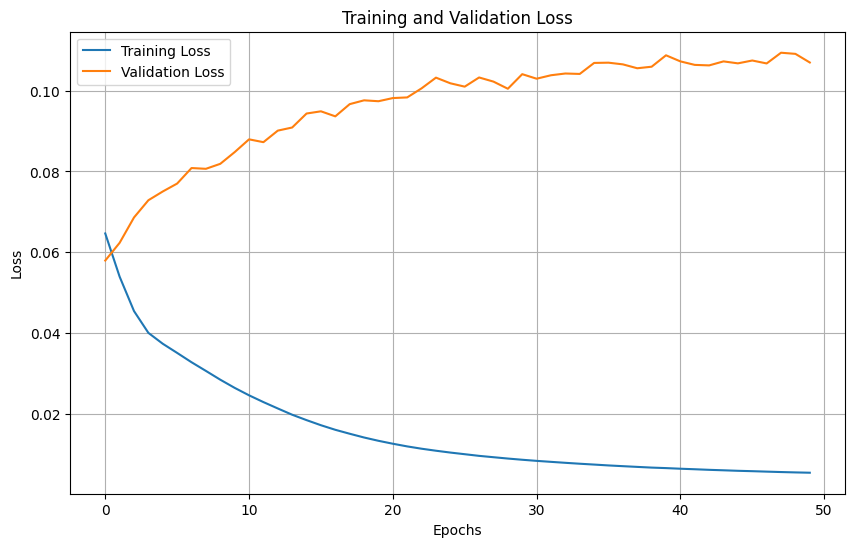

In [ ]:
opt_cnn.plot_losses()

In [ ]:
cnn_pred, cnn_val = opt_cnn.evaluate(test_loader)
cnn_pred, cnn_val = np.array(cnn_pred), np.array(cnn_val)
cnn_mse = np.mean(np.square(cnn_pred - cnn_val))
print(f"MSE for CNN on test data: {cnn_mse}")

MSE for CNN on test data: 0.1069348081946373


# Conditional Variation AutoEncoder (CVAE)

## 1. Autoencoder (AE)

![AE Architecture](https://media.geeksforgeeks.org/wp-content/uploads/20240515023125/Screenshot-2024-05-15-022904.png)

### Motivation
- Reduce dimensionality (like PCA) while preserving key features.

### What It Does
- Compresses input data $x$ into a low-dimensional representation $z$ using an **encoder**.
- Reconstructs the input $x'$ from $z$ using a **decoder**.
- Trains by minimizing the **reconstruction loss** (e.g., mean squared error) between $x$ and $x'$.

\\

## 2. Variational Autoencoder (VAE)

![VAE Architecture](https://miro.medium.com/v2/resize:fit:1400/0*SZ5esrCn2MDKmpHe.png)

### Motivation
For simple autoencoders:
- The latent space is **fixed and unstructured**, so it **cannot generate** new, plausible data points.
- Without regularization, the latent space becomes **messy**, leading to poor generalization and overfitting.
- They cannot model **uncertainty** in the data, as they don't use probabilistic reasoning.


### What It Does
- Introduces a **probabilistic latent space**:
  - Encoder maps $x$ to the parameters of a Gaussian distribution ($\mu, \sigma^2$) instead of a fixed $z$.
  - A latent vector $z$ is sampled as:
    $$
    z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
    $$
- Decoder reconstructs $x'$ from $z$.
- Trains by minimizing:
  - **Reconstruction Loss**: Ensures $x'$ is close to $x$.
  - **KL Divergence**: Regularizes $q(z|x)$ to match a prior $p(z)$ (typically $\mathcal{N}(0, I)$).



### Unusual Aspects
- **Reparameterization Trick**:
Ensures gradients can flow during backpropagation:
    $$
    z = \mu + \sigma \cdot \epsilon
    $$
    
\\

## 3. Conditional Variational Autoencoder (CVAE)

![CVAE Architecture](https://www.researchgate.net/publication/365190062/figure/fig2/AS:11431281095388874@1667878234857/Structure-of-the-conditional-variational-autoencoder-CVAE.png)

### Motivation
- Need for controlled generation and the incorporation of contextual information which VAEs can't do (e.g., generate data based on labels or external factors).

### What It Does
- Extends VAEs by conditioning both the encoder and decoder on additional **contextual information** $c$:
  - Encoder maps $[x, c]$ to $\mu, \sigma^2$.
  - Decoder reconstructs $x'$ from $[z, c]$.
- $c$ can represent labels, external features, or auxiliary variables.

### Unusual Aspects
- **Probabilistic Backpropagation**:
  - Gradients flow through both $z$ and the condition $c$.
- **Flexible Generation**:
  - At inference, different $c$ values allow context-specific outputs.


In [46]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, condition_dim):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        # Encoder
        self.fc_e1 = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc_d1 = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)


    def encode(self, x, c):
        # Concatenate input and condition
        # print('x: ', x.shape)
        # print('c: ', c.shape)
        x_c = torch.cat((x, c), dim=2)
        h1 = F.relu(self.fc_e1(x_c))
        mean = self.fc_mean(h1)
        logvar = self.fc_logvar(h1)
        return mean, logvar


    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


    def decode(self, z, c):
        # Concatenate latent vector and condition
        z_c = torch.cat((z, c), dim=2)
        h3 = F.relu(self.fc_d1(z_c))
        out = self.fc_out(h3)
        return out


    def forward(self, x, c):
        mean, logvar = self.encode(x, c)
        z = self.reparameterize(mean, logvar)
        out = self.decode(z, c)
        return out, mean, logvar

Why Choose These Features?
𝑥
x: Directly drives the prediction task, representing primary predictors for
𝑦
y.
𝑦
y: Model output, representing energy use categories.
𝑐
c: Environmental factors that condition the system behavior (e.g., temperature affects both heating and cooling).

In [24]:
condition_labels = ['temperature', 'humidity']
dfC_train, _ = get_input_output(df_train, condition_labels, condition_labels)
dfC_test, _ = get_input_output(df_test, condition_labels, condition_labels)

# Scale condition data
scaler_c, C_train_sc, C_test_sc = scaler_fit_transform(dfC_train, dfC_test)

In [25]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, c, seq_len=1):
        """
        X: Input features (time series data).
        y: Target features (to be predicted).
        c: Condition features (e.g., external factors like weather).
        seq_len: Sequence length for the time series.
        """
        self.X = X
        self.y = y
        self.c = c
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len - 1)

    def __getitem__(self, index):
        X_seq = self.X[index:index + self.seq_len]
        y_seq = self.y[index:index + self.seq_len]
        c_seq = self.c[index:index + self.seq_len]
        return (X_seq, y_seq, c_seq)

In [26]:
def set_loader(X_train, y_train, C_train, X_test, y_test, C_test, seq_len, batch_size):
    """
    X_train, y_train: Scaled training input and target data.
    C_train: Scaled training condition data.
    X_test, y_test: Scaled test input and target data.
    C_test: Scaled test condition data.
    seq_len: Sequence length for time series.
    batch_size: Batch size for the DataLoader.
    """
    train_dataset = TSDataset(
        torch.Tensor(X_train),
        torch.Tensor(y_train),
        torch.Tensor(C_train),
        seq_len
    )
    test_dataset = TSDataset(
        torch.Tensor(X_test),
        torch.Tensor(y_test),
        torch.Tensor(C_test),
        seq_len
    )
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, drop_last=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [27]:
seq_len = 24*7
batch_size = 16
train_dataset, test_dataset, train_loader, test_loader = set_loader(
    X_train_sc, y_train_sc, C_train_sc,
    X_test_sc, y_test_sc, C_test_sc,
    seq_len, batch_size
)

In [40]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, device):
        """
        model: selected model
        loss_fn: loss function
        optimizer: function to optimize loss
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y, c):
        """
        x: input data
        y: target data
        c: condition data
        """
        self.model.train()

        # Forward pass
        yhat, mean, logvar = self.model(x, c)

        # Compute reconstruction loss
        recon_loss = self.loss_fn(yhat, y)

        # Compute KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        kl_loss /= x.size(0)  # Normalize by batch size

        # Total loss
        loss = recon_loss + kl_loss

        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, train_loader, val_loader, n_epochs=50, n_features=1):
        """
        train_loader: training data
        val_loader: validation data
        n_epochs: number of epochs
        n_features: number of features
        """
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch, c_batch in train_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                c_batch = c_batch.to(self.device)
                loss = self.train_step(x_batch, y_batch, c_batch)
                batch_losses.append(loss)

            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            # Validation phase
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val, c_val in val_loader:
                    x_val = x_val.to(self.device)
                    y_val = y_val.to(self.device)
                    c_val = c_val.to(self.device)
                    self.model.eval()
                    yhat, mean, logvar = self.model(x_val, c_val)

                    # Validation loss
                    recon_loss = self.loss_fn(yhat, y_val)
                    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                    kl_loss /= x_val.size(0)  # Normalize by batch size

                    val_loss = recon_loss + kl_loss
                    batch_val_losses.append(val_loss.item())

                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        test_loader: dataLoader
        batch_size: batch size
        n_features: number of features
        """
        with torch.no_grad():
            predictions = []
            values = []
            conditions = []
            for x_test, y_test, c_test in test_loader:
                x_test = x_test.to(self.device)
                y_test = y_test.to(self.device)
                c_test = c_test.to(self.device)

                self.model.eval()
                yhat, _, _ = self.model(x_test, c_test)

                predictions.append(yhat.cpu().data.numpy())
                values.append(y_test.cpu().data.numpy())
                conditions.append(c_test.cpu().data.numpy())

        return predictions, values, conditions

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()

In [49]:
input_d = 4
hidden_d = 16
output_d = 4
lrate = 1e-4
condition_dim = 2
weight_decay = 1e-6
loss_fn = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

model_cvae = CVAE(input_d, hidden_d, latent_dim=2, output_dim=output_d, condition_dim=condition_dim).to(device)
optimizer_cvae = optim.Adam(model_cvae.parameters(), lr=lrate, weight_decay=weight_decay)
opt_cvae = Optimization(model_cvae, loss_fn, optimizer_cvae, device)

[1/50] Training loss: 0.6529	 Validation loss: 0.1253
[2/50] Training loss: 0.1139	 Validation loss: 0.0715
[3/50] Training loss: 0.0660	 Validation loss: 0.0586
[4/50] Training loss: 0.0592	 Validation loss: 0.0567
[5/50] Training loss: 0.0581	 Validation loss: 0.0562
[6/50] Training loss: 0.0575	 Validation loss: 0.0559
[7/50] Training loss: 0.0571	 Validation loss: 0.0557
[8/50] Training loss: 0.0568	 Validation loss: 0.0554
[9/50] Training loss: 0.0566	 Validation loss: 0.0553
[10/50] Training loss: 0.0564	 Validation loss: 0.0551
[11/50] Training loss: 0.0562	 Validation loss: 0.0551
[12/50] Training loss: 0.0561	 Validation loss: 0.0550
[13/50] Training loss: 0.0560	 Validation loss: 0.0549
[14/50] Training loss: 0.0558	 Validation loss: 0.0550
[15/50] Training loss: 0.0557	 Validation loss: 0.0552
[16/50] Training loss: 0.0555	 Validation loss: 0.0551
[17/50] Training loss: 0.0554	 Validation loss: 0.0553
[18/50] Training loss: 0.0553	 Validation loss: 0.0554
[19/50] Training lo

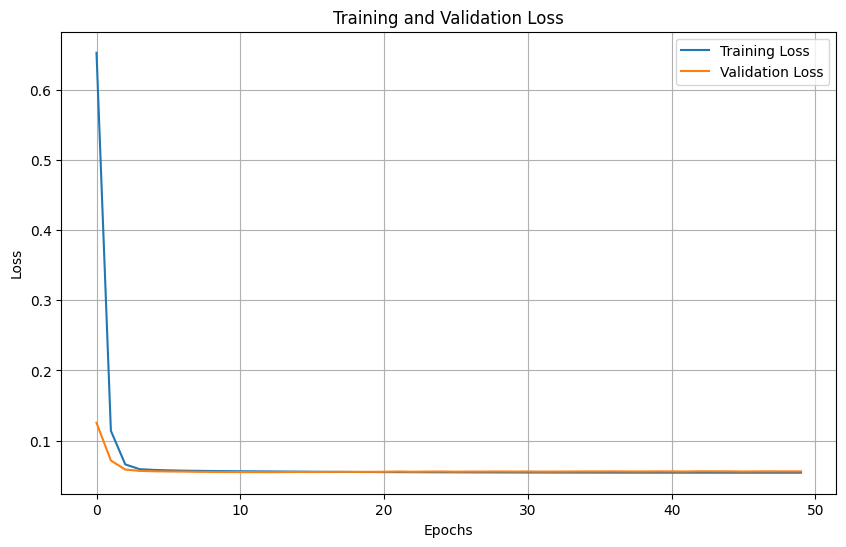

In [50]:
opt_cvae.train(train_loader, test_loader, n_epochs=50)
opt_cvae.plot_losses()